In [1]:
#import Spark and MLlib packages
from pyspark import SparkContext, SparkConf
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.clustering import KMeans
from math import sqrt, fabs

#import data analysis packages
import numpy as np
import pandas as pd
import sklearn

from pandas import Series, DataFrame
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from numpy import array

from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs

#import data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#misc packages
from __future__ import division
from __future__ import print_function

In [2]:
#I.Generate the two dimensional dataset 
#with three cluster centroid
np.random.seed(0)
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

In [3]:
#Clustering with KMeans
K_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
K_means.fit(X)

#Return labels and cluster centers
K_means_labels = K_means.labels_
K_means_cluster_centers = K_means.cluster_centers_
K_means_inertia = K_means.inertia_
#find the unique elements
K_means_labels_unique = np.unique(K_means_labels)

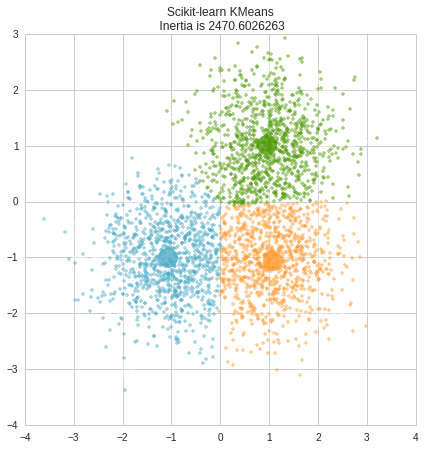

In [4]:
# Plot result
fig = plt.figure(figsize=(7, 7))
colors = ['#4EACC5', '#FF9C34', '#4E9A06']
ax = fig.add_subplot(111)

for k, col in zip(range(n_clusters), colors):
    my_members = K_means_labels == k
    cluster_center = K_means_cluster_centers[k]
    
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.', alpha=0.5)
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, alpha=0.8,
            markeredgecolor='k', markersize=20)

ax.set_title('Scikit-learn KMeans \n Inertia is {}'.format(K_means_inertia))

In [5]:
#dump the tips to a local file for now
X_data_size = len(X[:,0])

fo = open("/usr/local/spark/examples/src/main/resources/k_means.data", "w")
for i in range(X_data_size):    
    fo.write("{} {}\n".format(float(X[:,0][i]), float(X[:,1][i]))) 

fo.close()

In [6]:
#IV Use MLlib
sc = SparkContext("local", "K_Means")

In [7]:
data = sc.textFile('/usr/local/spark/examples/src/main/resources/k_means.data')

In [8]:
#Split the training set and test set
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

In [12]:
# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 3, maxIterations=10,
        runs=10, initializationMode="random")

In [13]:
#Predication
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point-center)]))

WSSSE = parsedData.map(lambda point:error(point)).reduce(lambda x, y: x+y)
print("PySpark K-means Sum of Squared Error {}".format(WSSSE))

PySpark K-means Sum of Squared Error 2450.4030891
